Mnist Baseline 

Step 1 : load Mnist Dataset

In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train = True , download=True, transform=transform)

transform = transforms.Compose([...])
This line creates a transformation pipeline for the MNIST images, including:

transforms.ToTensor(): Converts each MNIST image from a PIL image (or numpy array) to a PyTorch tensor, which is required for model training.

transforms.Normalize((0.1307,), (0.3081,)): Normalizes the pixel values using the dataset's mean (0.1307) and standard deviation (0.3081). Normalization helps training converge faster and improves performance by ensuring all pixel values are on a similar scale.

train_dataset = datasets.MNIST(...)
This loads the MNIST training dataset from ./data directory. It:

Downloads the data if it doesn’t exist yet.

Applies the transformations defined above to each image, prepping the data for use in PyTorch models.

In [5]:
print(f"Number of training samples: {len(train_dataset)}")

Number of training samples: 60000


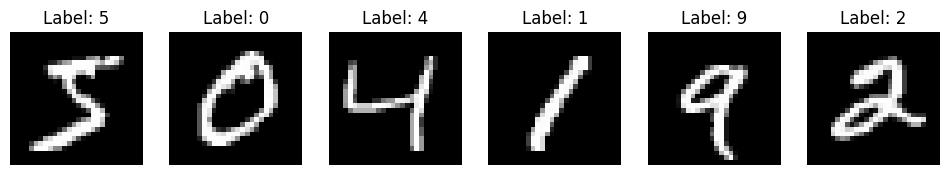

In [6]:
fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    image, label = train_dataset[i]
    image = image.squeeze()  # remove channel dimension for plotting
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.show()


Set Up DataLoader for Training
PyTorch’s DataLoader helps you:
*Batch the data for efficient training
*Shuffle data for randomness in each epoch
*Load data as needed, saving memory

In [8]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Define the Classic CNN Model
Let’s start with a simple LeNet-style architecture.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()


This model takes 28x28 MNIST images, extracts features with convolutional and pooling layers, flattens the features, and classifies the digits 0–9 with the output layer.

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()     # For multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

1. Loss Function:

python
criterion = nn.CrossEntropyLoss()
Purpose: Measures how well your model's predictions match the true labels.

Why CrossEntropy? For multiclass classification, like digit recognition (0–9), cross-entropy quantifies the difference between your model's predicted probabilities and the actual digit class. It gives a higher penalty for confident but wrong guesses, encouraging better learning.

2. Optimizer:

python
optimizer = optim.Adam(model.parameters(), lr=0.001)
Purpose: Updates the model's weights after each batch of training data to reduce the loss.

Why Adam? Adam is an advanced optimizer that adapts learning rates for different parameters, often leading to faster and more stable training compared to plain SGD.

Parameters:

model.parameters(): Tells Adam which model weights to update.

lr=0.001: Starting learning rate (how much weights change in response to calculated error).

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 1  # We'll start with 1 epoch for demonstration

for epoch in range(num_epochs):
    model.train()  # set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()                   # reset gradients
        outputs = model(images)                 # forward pass
        loss = criterion(outputs, labels)       # compute loss
        loss.backward()                         # backward pass
        optimizer.step()                        # update weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/1, Loss: 0.1403


In [13]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradients for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.19%


Train for more epochs to see if accuracy improves

In [14]:
num_epochs = 10 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 0.0431
Epoch 2/10, Loss: 0.0299
Epoch 3/10, Loss: 0.0207
Epoch 4/10, Loss: 0.0157
Epoch 5/10, Loss: 0.0130
Epoch 6/10, Loss: 0.0114
Epoch 7/10, Loss: 0.0080
Epoch 8/10, Loss: 0.0084
Epoch 9/10, Loss: 0.0065
Epoch 10/10, Loss: 0.0073


In [15]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradients for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.94%


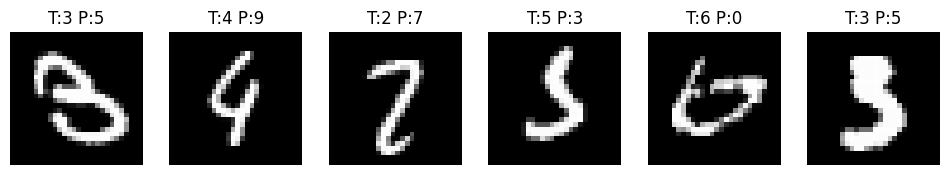

In [16]:
import numpy as np

# Store misclassified images, their predicted and true labels
misclassified = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for img, true, pred in zip(images, labels, predicted):
            if true != pred:
                misclassified.append((img.cpu(), true.cpu(), pred.cpu()))
            if len(misclassified) >= 6:
                break
        if len(misclassified) >= 6:
            break

fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i, (img, true, pred) in enumerate(misclassified[:6]):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"T:{true} P:{pred}")
    axes[i].axis('off')
plt.show()


In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)  # Add dropout with probability 0.25
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # Increase neuron count (was 128)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)              # Apply dropout before fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


1. Dropout Layer (nn.Dropout(0.25)):

What: Randomly sets 25% of its input units to zero during each training step.

Why: Prevents the network from becoming too reliant (“overfitting”) on particular features, encouraging it to learn more general patterns that work well on unseen data.

2. Increased Neurons in fc1 Layer (nn.Linear(64*7*7, 256)):

What: Expands the fully connected layer from 128 neurons to 256.

Why: More neurons give the network greater capacity to learn complex patterns and relationships in the data.

Effect: Sometimes leads to better accuracy, especially for difficult tasks; but can also increase risk of overfitting if unchecked (which is why dropout helps here).

How it works in forward pass:

Images move through feature extraction layers (conv, pool).

The resulting feature tensor is flattened.

Dropout randomly zeroes out parts of the feature tensor.

The dropped-out tensor goes through a larger fully connected layer (256 neurons), activated by ReLU.

Final layer produces probability logits for each digit class.

Summary:

Dropout = better generalization (less overfit).

More neurons = higher learning capacity.

Used together, they should help your model stay accurate on both training and test data—even if you make it deeper or more complex!

In [19]:
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/1, Loss: 0.1333


In [21]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradients for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.60%


we can see after experiment with architecture/tuning , test accuracy has increase 

In [22]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 0.0468
Epoch 2/5, Loss: 0.0327
Epoch 3/5, Loss: 0.0263
Epoch 4/5, Loss: 0.0229
Epoch 5/5, Loss: 0.0173


In [23]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradients for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 99.21%


Achieved more accuracy on this architecture

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # <- new layer
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128*3*3, 256)  # Adjust for new conv layer
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))    # <- new layer used
        x = x.view(-1, 128*3*3)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [28]:
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Add Another Convolutional Layer
Try adding one more convolutional layer (e.g., conv3) to your SimpleCNN:
And in the forward() method

In [29]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/1, Loss: 0.1427


In [30]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradients for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.86%


Data Augmentation

Update the transform for your training dataset:

In [31]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomRotation(10),  # Randomly rotate images by up to ±10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


Re-instantiate your training dataset with the new transform:

In [32]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Retrain your model and compare test accuracy and misclassifications.

In [35]:
num_epochs = 1  # You can increase or decrease as needed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)  # Re-instantiate after any changes!
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/1, Loss: 0.1647


In [36]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradients for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.90%


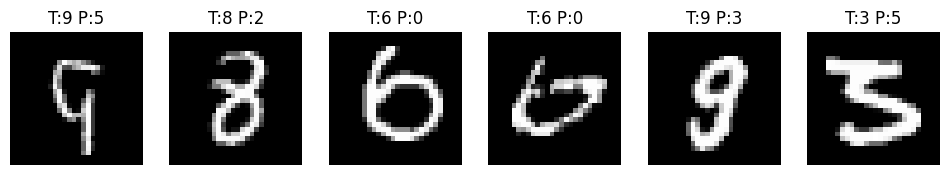

In [37]:
# Store misclassified images, their predicted and true labels
misclassified = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for img, true, pred in zip(images, labels, predicted):
            if true != pred:
                misclassified.append((img.cpu(), true.cpu(), pred.cpu()))
            if len(misclassified) >= 6:
                break
        if len(misclassified) >= 6:
            break

fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i, (img, true, pred) in enumerate(misclassified[:6]):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"T:{true} P:{pred}")
    axes[i].axis('off')
plt.show()


Data augmentation simulates “real-world” scenarios for digit recognition, which encourages the network to learn more generalizable features and reduces overfitting to the training set.

In [38]:
# Save only the model parameters (recommended)
torch.save(model.state_dict(), 'mnist_cnn.pth')